# <p align="center"> TERM PAPER PHY: Simulation of the nuclear shell-model with digital quantum computers</p>
#### <p align="center">CARLOS RAMON ESCANDELL</p>
##### <p align="center">Fall semester 2024</p>

In this Jupyter notebook, I will provide all the code used to make the simulations detailed in the Term Paper. My objective is that going throught the code you can understand the process of how I did the simulations and the results obtained. Probably there are more efficient ways to do it, all suggestions to improve as well as any questions are welcome, feel free to contact me at carlos.ramonescandell@mail.utoronto.ca

The first step consists on installing the python libraries that we will use:
- `openfermion` to deal with the fermionic operators and perform the Jordan-Wigner mapping as we will detail later
- `qibo` to simulate the quantum circuits.
  

In [1]:
! pip install openfermion

In [2]:
! pip install qibo

As mentioned in the Term paper, I restricted myself to the simulation of 3 small nuclei:
- `Litium-6` (2 valence nucleons at the p shell)
- `Beryllium-10` (6 valence nucleons at the p shell)
- `Oxygen-18` (2 nucleons at the sd shell)

Also mentioned in the report, the Hamiltonian in a given configuration space is

$$
H_{\text{eff}} = \sum_i \epsilon_i a^{\dagger}_i a_i +\frac{1}{4}\sum_{ijkl} \overline{v}_{ijkl}a^{\dagger}_i a^{\dagger}_ja_l a_k.
$$
This Hamiltonian is obtained by using standard phenomenological Hamiltonians, with components adjusted to better reproduce key properties of selected nuclei, we have used the Cohen-Kurath interaction for the p-shell and the USDB in the sd shell.

At the folder `input` we have the files with the corresponding Hamiltonian for the nucleis mentioned before as well as their single-particle basis. 

In [1]:
# First of all let me introduce all the libraries and functions that we will use throughout the notebook.
# QC Libraries
from qibo import gates
from qibo.models import Circuit
#--------------------------------------
# OpenFermion Libraries
#--------------------------------------
from openfermion.ops import FermionOperator
from openfermion.linalg import get_sparse_operator
from openfermion.utils import hermitian_conjugated
from scipy.optimize import minimize
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from openfermion.transforms import jordan_wigner
#--------------------------------------
# others
import numpy as np
from scipy.sparse.linalg import eigsh
import re
import time


Next, I will start to write at each cell the functions that I will later use. I tried to provide with each function a small description of what is doing the function

In [2]:
# First one function to convert a binary list to a decimal number
def binary_to_decimal(list,nqubits):
    """
    Input: list of 1s and 0s.
    Output: decimal number associated to the binary list.
    """
    decimal  = 0
    for i in range(nqubits):
        decimal += list[i] * (2**(len(list)-i-1))
    return decimal

In [3]:
def slatertofocklbasis(slater_det, nqubits): 
    """
    This function converts a list of vectors expressed in Slater basis to a list of vectors expressed in "Fock basis".
    Input: list of vectors expressed in Slater basis
    Output: list of vectors expressed in "Fock basis"
    """
    qbit_vectors = [] 
    n1 = nqubits

    for element in slater_det:
        qbit_basis_vect = [0 for i in range(n1)]
        for num in element:
            qbit_basis_vect[num] = 1

        qbit_vectors.append(qbit_basis_vect)

    list_fock_basis = []
    for element in qbit_vectors:
        num = binary_to_decimal(element,nqubits)
        list_fock_basis.append(num)
    
    return list_fock_basis

In [4]:
#This function computes all the nonzero fermion operatos in this basis:
def NonZeroFermionicOperators(BasisVectors,FileName):
    """
    Input (list): This function receives a list of all the vectors of the basis.
    Output (list) : List of all the Non Zero Fermionic operators.
    """
    start_time = time.time()
    non_zero_operators = []  # list where we will store all the non-zero fermionic operators
    
    # first we detect which is the largest and the smallest number in the basis:
    components = [x for tup in BasisVectors for x in tup]

    maxc = max(components)
    minc = min(components)

    # we now iterate creating all possible fermionic operators
    with open(FileName, "w") as f:
        for p in range(minc, maxc+1):
            for q in range(p, maxc+1):
                for r in range(minc, maxc+1):
                    for s in range(r, maxc+1):
                        for i in range(len(BasisVectors)):
                            for j in range(i, len(BasisVectors)):

                                vec1 = BasisVectors[i]
                                vec2 = BasisVectors[j]

                                if (p != q and (p in vec1) and (q in vec1) and (s != r) and (s in vec2) and (r in vec2)):  

                                    vec1_copy = vec1.copy()
                                    vec2_copy = vec2.copy()

                                    OF_Operator = FermionOperator(((p, 1), (q, 1), (r, 0), (s, 0)))
                                    # now we have to select only those operators which have the same terms in the bra as in the ket

                                    vec2_copy.remove(s)
                                    vec1_copy.remove(p)
                                    vec2_copy.remove(r)
                                    vec1_copy.remove(q)

                                    if (vec1_copy == vec2_copy) and (OF_Operator not in non_zero_operators):                                       

                                        non_zero_operators.append(OF_Operator)
                                        f.write(str(OF_Operator) + "\n")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Non-zero fermionic operators calculation: ",elapsed_time)
    return(non_zero_operators)

In [5]:
def transformH(file, Slater_basis, nqubits):
    """
    INPUT: file (str) -> file name that has the hamiltonian
           Slater_basis (list) -> basis of the Hamiltonian
           nqubits (int) -> number of qubits

    OUTPUT: H (csr_matrix) in the computational basis
    """
    # read file
    with open(file, 'r') as f:
        data = [line.strip().split() for line in f]

    rows, cols, values = zip(*((int(line[0]), int(line[1]), float(line[2])) for line in data))

    # build the hamiltonian
    dim = len(Slater_basis)
    hamiltonian_Slaterbasis = np.zeros((dim, dim))
    hamiltonian_Slaterbasis[rows, cols] = values

    # transform the Hamiltonian to the computational basis
    n = 2**nqubits
    hamiltonian_compbasis = np.zeros((n, n))

    vectors_fock = slatertofocklbasis(Slater_basis, nqubits)

    for i, j, value in zip(rows, cols, values):
        index1, index2 = vectors_fock[i], vectors_fock[j]
        hamiltonian_compbasis[index1, index2] = value

    hamiltonian_sparse = csr_matrix(hamiltonian_compbasis)

    return hamiltonian_sparse

In [6]:
def StateMinEnergy(file,Slater_basis):
    '''
    This function picks the state of the Hamiltonian that has the minimum energy.
    We will use this function to pick the state from which we will start the optimization.
    '''
    with open(file, 'r') as f:
        data = [line.strip().split() for line in f]

    filas = [int(linea[0]) for linea in data]
    values = [float(linea[2]) for linea in data]

    min_value = min(values)
    index = values.index(min_value)
    index_slater = filas[index]
    min_vector = Slater_basis[index_slater]

    return min_vector, min_value

In [7]:
def separar_elementos(T_qubit_str):
    '''
    This function takes each of the NonZeroFermionicOperators and separates them into their respective coefficients, gates and the qubit where this gate is applied
    once we have performed the JW transformation to the Fermionic operator.
    '''
    coeficientes = []
    puertas = []
    numeros = []

    terminos = re.findall(r'[(]-?[\d.]+[+]?[\d.]+j[)] [\w\d\s\[\]]+', T_qubit_str)

    for term in terminos:
        coef = re.search(r'[-+]?[\d.]+[+]?[\d.]+j', term)
        coeficientes.append(complex(coef.group()))

        puertas_term = re.findall(r'([XYZ]\d+)', term)
        puertas_numeros = [re.split(r'(\d+)', puerta_numero) for puerta_numero in puertas_term]

        puertas.extend([pn[0] for pn in puertas_numeros])
        numeros.extend([int(pn[1]) for pn in puertas_numeros])

    return coeficientes, puertas, numeros

In [8]:
def str_to_gate(string,number):
    """
    This function converts a string when readed to its respective gate into the circuit.
    """
    if string == 'X':
        gate = gates.X(number)
    elif string == 'Y':
        gate = gates.Y(number)
    elif string == 'Z':
        gate = gates.Z(number)
    return gate

In [9]:
def initial_state(initial_vector,nqubits):
    """
    This function implements the quantum circuit that prepares the initial state.
    """
    qc = Circuit(nqubits)
    qbitbasisvect = [0 for i in range(nqubits)]

    for element in initial_vector:
        qbitbasisvect[element] = 1

    for i in range(nqubits):
        if qbitbasisvect[i] == 1:
            qc.add(gates.X(i))

    print(qc.draw())

    return qc

In [10]:
def swap_elements(input_file_path, output_file_path):
    """
    This function is used to compute the T operators swapping the first two numbers in the input file and using the third and fourth numbers from the same line.
    """
    with open(input_file_path, 'r') as input_file, open(output_file_path, 'w') as output_file:
        # Regular expression to parse input lines
        line_regex = re.compile(r'(\d+\.\d+) \[(\d+)\^ (\d+)\^ (\d+) (\d+)\]')

        # Iterate through all the lines in the input file
        for line in input_file:
            # Match the input line with the regex
            match = line_regex.match(line.strip())

            if match:
                # Extract matched elements
                value, first_num, second_num, third_num, fourth_num = match.groups()

                # Reconstruct the output line by swapping the first two numbers and using the third and fourth numbers from the same line
                output_line = f"{value} [{third_num}^ {fourth_num}^ {first_num} {second_num}]"

                # Write the output line to the output file
                output_file.write(output_line + '\n')

In [11]:
def FermionOperatorMaxGradient(FileFermions,FileFermionsSwap,vector,sparse_H,nqubits):
    """
    This function computes the maximum gradient for a given vector.
    INPUT:
    FileFermions: File with the non zero fermion operators.
    vector: The vector in which we want to compute the maximum gradient.
    sparse_H: The sparse Hamiltonian matrix.
    nqubits: Number of qubits.
    OUTPUT:
    max_T: list with all the operators T that gives the maximun gradient.
    """

    values = []
    operadors_utilitzats = []
    
    # We compute the bra outside the loop since it is the same always, it does not depend on the fermionic operator.
    bra = np.conj(sparse_H.dot(vector)).transpose()

    with open(FileFermions, "r") as FermionOperators1, open(FileFermionsSwap, "r") as FermionOperators2:
        lines1 = FermionOperators1.readlines()
        lines2 = FermionOperators2.readlines()
        for (line1,line2) in zip(lines1,lines2):

            FO = FermionOperator(line1)
            FO_conj = FermionOperator(line2)

            T = 1.0j * (FO - FO_conj) # T = 1.0j * (FO - FO.conjugate())

            # Extract the specified row from the sparse operator as a sparse vector
            ket = get_sparse_operator(T, nqubits).dot(vector)
            valor = abs(2.0*(bra.dot(ket)[0,0]).imag)
            
            if valor != 0.0:
                values.append(valor)
                operadors_utilitzats.append(T)
                #print("Gradient value:", valor)
            

    Maxvalor = max(values)
    max_T = [operadors_utilitzats[i] for i in range(len(values)) if values[i] == Maxvalor]
    print(max_T)

    return max_T

In [12]:
def transform_gates(gates_list):
    """
    This function recieves a list of string gates and returns a list of the gates transformed to implement
    the staircase algorithm.
    """
    transformed_gates = []
    for gate in gates_list:
        if gate == 'X':
            transformed_gates.append('H Z H')
        elif gate == 'Y':
            transformed_gates.append('R1 Z R2')
        else:
            transformed_gates.append(gate)
    return transformed_gates

In [13]:
def unique_elements(input_list):
    """
    This function recieves a list and returns a list with the unique elements of the input list.
    """
    unique_set = set(input_list)
    unique_list = list(unique_set)
    return unique_list

In [14]:
def organize_qbit_gates(qbit_list, unique_numbers):
    """
    This function recieves a list of gates and a list of unique numbers and returns a list of lists of all the gates we 
    have to implement in each qbit.
    """
    n = len(unique_numbers)
    return [qbit_list[i:i+n] for i in range(0, len(qbit_list), n)]

In [178]:
# This function implements the staircase algorithm explained in the Term Paper. Its implementation is crucial to perform the algorithm.
def staircasealgorithm(theta, T, nqubits):
    """
    Here we implement the Staircase algorithm. We recieve a list of lists of gates, a list of numbers of the qbits, a list of
    coefficients and the number of qbits. We return a list of circuits. This function is used to implement the evolution of
    exp(iTtheta) with a quantum circuit.
    """

    global_circuit = []
    theta = float(theta)


    theta = float(theta)
    T_qbits = jordan_wigner(T)
    T_qbits_str = str(T_qbits)

    coef_list, gates_transformed, nums_transformed = separar_elementos(T_qbits_str) #we tranform the string to a list of coefficients, gates and numbers
    staircase1 = transform_gates(gates_transformed) #this list has the gates transformed to implement the staircase algorithm. We have to reaorganize it in order to implement it in the quantum circuit.
    number_list = sorted(unique_elements(nums_transformed))
    #number_list = list(number_list.sort()) #list of the unique numbers
    

    qbits_list = organize_qbit_gates(staircase1.copy(), number_list) #this list has the gates transformed and reorganized to implement the staircase algorithm


    for index in range(len(qbits_list)):
        qc = Circuit(nqubits)

        coef = coef_list[index] # We will multiply the RZ gate by this coefficient to get the correct value.

        # Add Hadamard and RX gates at the beginning of the circuit
        for number, gate_string in zip(number_list, qbits_list[index]):
            if gate_string == 'H Z H':
                qc.add(gates.H(number))
            elif gate_string == 'R1 Z R2':
                qc.add(gates.RX(number, -np.pi / 2))

        # Add the main part of the circuit
        for number, gate_string in zip(number_list, qbits_list[index]):
            # Add the cascade of CNOT gates before the RZ gate
            if number != (max(number_list)):
                if gate_string == 'H Z H' or gate_string == 'R1 Z R2' or gate_string == 'Z':
                    index1 = number_list.index(number)
                    qc.add(gates.CNOT(number_list[index1], number_list[index1 + 1]))

            # Add the RZ gate and then the second cascade of CNOT gates
            elif number == (max(number_list)):
                qc.add(gates.RZ(max(number_list), 2 * coef * theta))

                for i in reversed(range(1, len(number_list))):
                    qc.add(gates.CNOT(number_list[i - 1], number_list[i]))

        # Add Hadamard and RX gates at the end of the circuit
        for number, gate_string in zip(number_list, qbits_list[index]):
            number = int(number)
            if gate_string == 'H Z H':
                qc.add(gates.H(int(number)))
            elif gate_string == 'R1 Z R2':
                qc.add(gates.RX(int(number), np.pi / 2))

        global_circuit.append(qc)

    
    final_circuit = Circuit(nqubits)

    for circuit in global_circuit:
        for gate in circuit.queue:
            final_circuit.add(gate)

    return final_circuit


In [179]:
def combined_simulation1(theta, initial_vector_circuit, nqubits, T_OF):
    """
    This function puts together the initial state circuit and the main circuit implementing the staircase algorithm.
    """
    combined_circuit = Circuit(nqubits)
    #theta = float(theta)

    main_circuit = staircasealgorithm(theta,T_OF, nqubits)

    # Add gates from the initial state circuit
    for gate1 in initial_vector_circuit.queue:
        combined_circuit.add(gate1)

    # Add gates from the main circuit
    for gate2 in main_circuit.queue:
        combined_circuit.add(gate2)

    # Simulate the combined circuit
    final_state = combined_circuit().state(numpy=True) # Returns in the computational basis
    print(combined_circuit.draw())
    return final_state, combined_circuit

In [180]:
def expected_value1(theta, initial_vector_circuit, hamiltonian, nqubits, T_OF):
    """
    This function computes the expected value of the Hamiltonian for a given theta.
    """
    theta = float(theta)

    psi, _ = combined_simulation1(theta, initial_vector_circuit, nqubits, T_OF)

    psic = np.conj(hamiltonian.dot(psi)).transpose()

    # Calculate the expectation value
    result = (psic.dot(psi)).real

    return result

In [181]:
def vector_circuit_iteration(thetas_list,list_T,initial_vector_circuit,nqubits):
    """
    This function recieves a lista of theta's and a list of T's and it returns the corresponding circuit and the corresponding
    vector at the end of the circuit.
    """
    iteration_circuit = Circuit(nqubits)

    #combine all circuits in iteration_circuit into one circuit
    for gate1 in initial_vector_circuit.queue:
        iteration_circuit.add(gate1)
    
    for layer in range(len(thetas_list)):
        circuit_sector = (staircasealgorithm(thetas_list[layer], list_T[layer], nqubits))
        for gate2 in circuit_sector.queue:
            iteration_circuit.add(gate2)

    final_state = iteration_circuit().state(numpy=True)
    final_state_sparse = csr_matrix(final_state).transpose()

    return final_state_sparse, iteration_circuit

In [182]:
def expected_value_iteration(thetas_list,list_T,initial_vector_circuit,hamiltonian,nqubits):
    """
    This function recieves a list of thetas and a list of T's, and returns the expectation value of the hamiltonian
    """
    psi, _ = vector_circuit_iteration(thetas_list,list_T,initial_vector_circuit,nqubits)
    psic = np.conj(hamiltonian.dot(psi)).transpose()
    #Transform the final_vector to a sparse matrix:

    # Calculate the expectation value
    result = (psic.dot(psi)[0,0]).real

    return result

After defining these functions we have everything we needed to start the simulations.

In [166]:
# input parameters
HamiltonianFile = "input/hamiltonian_matrix_2_0.dat"
BasisFile = "input/many_body_states_2_0.dat"
nqubits = 12
epsilon = 0.1
initial_theta = 0.0

NucleiName = "Oxygen-18"

In [167]:
# We start reading the basis file and building all the non-zero Fermionic operators.
with open(BasisFile, 'r') as f:
    lines = f.readlines()[1:]
    vectors = [[int(i) for i in line.split('(')[1].split(')')[0].split(', ')] for line in lines]
NonZeroFermionicOperators(vectors, f"{NucleiName}/NonZeroFermionicOperators.out")
# Now we use the swap_elements function to create the T operators that we will use in the optimization.
swap_elements("Oxygen-18/NonZeroFermionicOperators.out", "Oxygen-18/NonZeroFermionicOperatorsSwap.out")

Non-zero fermionic operators calculation:  0.19078826904296875


In [469]:
# I create the Hamiltonian in the computational basis
H_sparse = transformH(HamiltonianFile, vectors, nqubits)

In [470]:
# I diagonaliize the Hamiltonian to obtain the GS energy for benchmarking my results.
def GS_benchmark(FileHamiltonian):
    # Read data from file
    with open(FileHamiltonian, "r") as f:
        data = np.loadtxt(f)

    # Construct sparse matrix from data
    hamiltonian = coo_matrix((data[:, 2], (data[:, 0].astype(int), data[:, 1].astype(int))))

    # Diagonalize Hamiltonian matrix and compute ground state energy
    evals, evecs = eigsh(hamiltonian, k=1, which="SA")
    ground_state_energy = evals[0]

    return ground_state_energy
GS_reference = GS_benchmark(HamiltonianFile)
print("GS Energy:",GS_reference)

GS Energy: -11.931788251561517


Next, let me start by computing the first $T_{rs}^{pq}$ that gives us the maximum gradient

In [471]:
energy_list = []

initial_vector, energy_1 = StateMinEnergy(HamiltonianFile, vectors)
energy_list.append(energy_1)
print(initial_vector)

initial_vector_circuit = initial_state(initial_vector,nqubits) #We have the circuit with the initial state

qbit_basis_vect = [0 if i not in initial_vector.copy() else 1 for i in range(nqubits)]
number = binary_to_decimal(qbit_basis_vect, nqubits)

length = 2**nqubits
initial_vector_comp = csr_matrix(([1], ([number], [0])), shape=(length, 1))

list_theta = []
list_T_OF = []
T_expr1 = FermionOperatorMaxGradient(f"{NucleiName}/NonZeroFermionicOperators.out", f"{NucleiName}/NonZeroFermionicOperatorsSwap.out", initial_vector_comp, H_sparse, nqubits)[0]
list_T_OF.append(T_expr1)
# Until here we have computed the first operator T that gives the maximum gradient.

[0, 5]
0 : ─X─
1 : ───
2 : ───
3 : ───
4 : ───
5 : ─X─
6 : ───
7 : ───
8 : ───
9 : ───
10: ───
11: ───
None
[1j [0^ 5^ 8 11] +
(-0-1j) [8^ 11^ 0 5]]


In [472]:
# Now we have to compute the first theta that gives the minimum energy and the value of the energy

res = minimize(lambda theta: expected_value1(theta, initial_vector_circuit, H_sparse, nqubits, T_expr1),
               [initial_theta], method='BFGS')

theta1 = res.x[0]
print("Theta value:",theta1)
list_theta.append(theta1)

print(list_theta)

energy = res.fun
energy_list.append(energy)
print("Energy_value:",energy)

C:\Users\carlo\AppData\Local\Temp\ipykernel_18580\3554281805.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta = float(theta)


0 :     ─X──H─o────────────────────────────────────o─H──H──o────────────────── ...
1 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
2 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
3 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
4 :     ────────────X─o────────────────────o─X───────────────────X─o────────── ...
5 :     ─X──H─────────X─o────────────────o─X─────────H──H──────────X─o──────── ...
6 :     ────────────────|────────────────|───────────────────────────|──────── ...
7 :     ────────────────|────────────────|───────────────────────────|──────── ...
8 :     ─H──────────────X─o────────────o─X───────────H──RX───────────X─o────── ...
9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── ...
10:     ────────────────────X─o────o─X───────────────────────────────────X─o── ...
11:     ─RX───────────────────X─RZ─X─────────────────RX─H──────────────────X─R ...

0 :

In [473]:
# new wavefunction after the first iteration 
vect_comp_T, vect_T_circuit = combined_simulation1(theta1, initial_vector_circuit, nqubits, T_expr1)
vect_comp_T = csr_matrix(vect_comp_T).transpose()

0 :     ─X──H─o────────────────────────────────────o─H──H──o────────────────── ...
1 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
2 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
3 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
4 :     ────────────X─o────────────────────o─X───────────────────X─o────────── ...
5 :     ─X──H─────────X─o────────────────o─X─────────H──H──────────X─o──────── ...
6 :     ────────────────|────────────────|───────────────────────────|──────── ...
7 :     ────────────────|────────────────|───────────────────────────|──────── ...
8 :     ─H──────────────X─o────────────o─X───────────H──RX───────────X─o────── ...
9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── ...
10:     ────────────────────X─o────o─X───────────────────────────────────X─o── ...
11:     ─RX───────────────────X─RZ─X─────────────────RX─H──────────────────X─R ...

0 :

In [474]:
# ITERATION
iteration = 1
while (abs(GS_reference)-abs(energy)) > epsilon:
    # Now we compute the next iteration of the algorithm:
    print("#-------------------------------------------------------")
    print("iteration:", iteration)

    T_expr = FermionOperatorMaxGradient(f"{NucleiName}/NonZeroFermionicOperators.out", f"{NucleiName}/NonZeroFermionicOperatorsSwap.out", vect_comp_T, H_sparse, nqubits)[0]
    list_T_OF.append(T_expr)

    res = minimize(lambda thetas: expected_value_iteration(thetas,list_T_OF,initial_vector_circuit, H_sparse, nqubits),
               list_theta + [initial_theta], method='BFGS',tol = 10**(-8))

    list_theta = list(res.x)
    print(list_theta)

    energy = res.fun
    energy_list.append(energy)
    print(energy)

    # Now we compute the new vector:

    vect_comp_T, vect_T_circuit = vector_circuit_iteration(list_theta,list_T_OF,initial_vector_circuit,nqubits)
    print(vect_T_circuit.draw())
    #print(vect_comp_T)
    iteration = iteration + 1

#-------------------------------------------------------
iteration: 1
[1j [0^ 5^ 6 7] +
(-0-1j) [6^ 7^ 0 5]]
[-0.152278238635498, -0.4730084315355678]
-10.109052363811733
0 :     ─X──H─o────────────────────────────────────o─H──H──o────────────────── ...
1 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
2 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
3 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
4 :     ────────────X─o────────────────────o─X───────────────────X─o────────── ...
5 :     ─X──H─────────X─o────────────────o─X─────────H──H──────────X─o──────── ...
6 :     ────────────────|────────────────|───────────────────────────|──────── ...
7 :     ────────────────|────────────────|───────────────────────────|──────── ...
8 :     ─H──────────────X─o────────────o─X───────────H──RX───────────X─o────── ...
9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── ...

In [475]:
# Saving data
iteration_list = []
for i in range(len(energy_list)):
    iteration_list.append(i)

with open(f"{NucleiName}/" + NucleiName + '_energy.out', 'w') as f:
    for i, energy in zip(iteration_list, energy_list):
        rel_error = abs((energy - GS_reference) / GS_reference)
        f.write(str(i) + ' ' + str(energy) + ' ' + str(rel_error) + '\n')
#----------------------------------------------------------------------------------------------------
# Now we save all the theta values on a file:
print(list_theta)
with open(f"{NucleiName}/"+ NucleiName + 'theta_values.out', 'w') as f:
    for theta in list_theta:
        f.write(str(theta) + '\n')

[-0.15726673731741528, -0.43716629520708855, 0.6046048304510659, 0.21439173104968076, -0.7853980200998655]


Let's do a quick plot of what we have obtained until now!

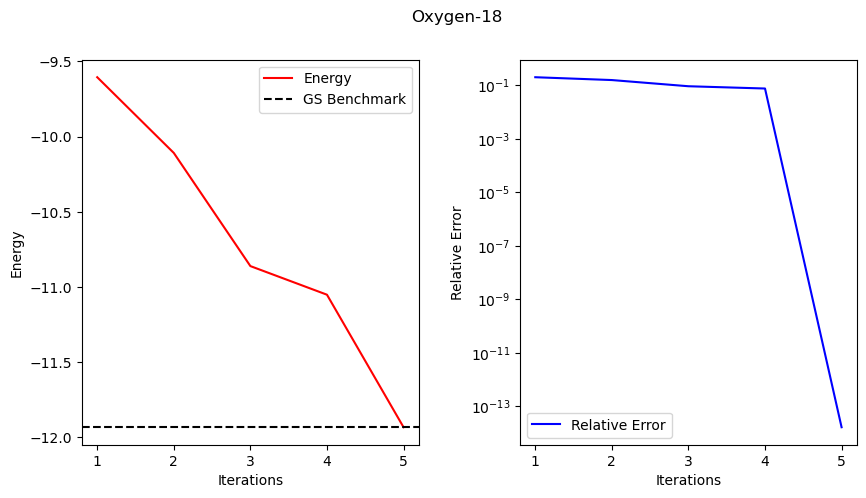

In [476]:
import matplotlib.pyplot as plt
import numpy as np
# Load data from file
data = np.loadtxt(f"{NucleiName}/" + NucleiName + '_energy.out')

# Extract columns from data
iterations = data[1:,0]
energy = data[1:,1]
rel_error = np.abs(data[1:,2])  # Take the absolute value of the relative error

# Create multiplot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot energy vs. iterations with benchmark on left subplot
ax1.plot(iterations, energy, 'r-', label="Energy")
ax1.axhline(y=GS_reference, color='k', linestyle='--', label="GS Benchmark")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Energy")
ax1.legend()
ax1.autoscale_view()  # Adjust axis to the data automatically

# Plot relative error vs. iterations on right subplot
ax2.plot(iterations, rel_error, 'b-', label="Relative Error")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Relative Error")

ax2.set_yscale("log")  # Set the y-axis to log scale
ax2.legend()

# Disable grid and minor ticks
ax2.grid(False)
ax2.minorticks_off()

ax2.autoscale_view()  # Adjust axis to the data automatically

# Add global title
fig.suptitle(NucleiName)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Save plot as PNG
plt.savefig(NucleiName + "multiplot.png")

# Show the plot
plt.show()

As we can see, with 5 iterations we are able to reach the value of the Ground State Energy with a relative error $\epsilon_E \approx 10^{-13}$ which is impressive!

Now let me proceed for the case of the Lithium-6 nucleus!

In [168]:
# setup
nqubits = 12
HamiltonianFile = "input/hamiltonian_matrix_p_1_1.dat"
BasisFile = "input/many_body_states_p_1_1.dat"
epsilon = 0.01
initial_theta = 0.0

NucleiName = "Lithium-6"

In [169]:
# We start reading the basis file and building all the non-zero Fermionic operators.
with open(BasisFile, 'r') as f:
    lines = f.readlines()[1:]
    vectors = [[int(i) for i in line.split('(')[1].split(')')[0].split(', ')] for line in lines]
NonZeroFermionicOperators(vectors, f"{NucleiName}/NonZeroFermionicOperators.out")
# Now we use the swap_elements function to create the T operators that we will use in the optimization.
swap_elements(f"{NucleiName}/NonZeroFermionicOperators.out", f"{NucleiName}/NonZeroFermionicOperatorsSwap.out")

Non-zero fermionic operators calculation:  0.05912208557128906


In [170]:
# I create the Hamiltonian in the computational basis
H_sparse = transformH(HamiltonianFile, vectors, nqubits)

In [171]:
# I diagonaliize the Hamiltonian to obtain the GS energy for benchmarking my results.
def GS_benchmark(FileHamiltonian):
    # Read data from file
    with open(FileHamiltonian, "r") as f:
        data = np.loadtxt(f)

    # Construct sparse matrix from data
    hamiltonian = coo_matrix((data[:, 2], (data[:, 0].astype(int), data[:, 1].astype(int))))

    # Diagonalize Hamiltonian matrix and compute ground state energy
    evals, evecs = eigsh(hamiltonian, k=1, which="SA")
    ground_state_energy = evals[0]

    return ground_state_energy
GS_reference = GS_benchmark(HamiltonianFile)
print("GS Energy:",GS_reference)

GS Energy: -5.5567832187164665


With Lithium-6 we have the problem that the minimum energy state from which we start to iterate, $|\psi_0\rangle = a_2^{\dagger}a_7^{\dagger}|\text{vac}\rangle$ causes the algorithm to get stucked in a local minimum. To circumvent this, we initialize the system from another state, $|\psi_0 \rangle = a_1^{\dagger}a_{11}^{\dagger}|\text{vac}\rangle$

In [97]:
# We start computing the first T that gives the maximum gradient:
energy_list = []
list_T_OF = []


_, energy_1 = StateMinEnergy(HamiltonianFile, vectors)
energy_list.append(energy_1)
print(energy_1)

initial_vector = [1,11]

print(initial_vector)
initial_vector_circuit = initial_state(initial_vector,nqubits) #We have the circuit with the initial state

qbit_basis_vect = [0 if i not in initial_vector.copy() else 1 for i in range(nqubits)]
number = binary_to_decimal(qbit_basis_vect, nqubits)

length = 2**nqubits
initial_vector_comp = csr_matrix(([1], ([number], [0])), shape=(length, 1))

list_theta = []
list_T_OF = []

T_expr1 = FermionOperatorMaxGradient(f"{NucleiName}/NonZeroFermionicOperators.out", f"{NucleiName}/NonZeroFermionicOperatorsSwap.out", initial_vector_comp, H_sparse, nqubits)[0]
list_T_OF.append(T_expr1)
print(list_T_OF)
# Until here we have computed the first operator T that gives the maximum gradient.

-2.6208250000000004
[1, 11]
0 : ───
1 : ─X─
2 : ───
3 : ───
4 : ───
5 : ───
6 : ───
7 : ───
8 : ───
9 : ───
10: ───
11: ─X─
None
[1j [1^ 11^ 5 7] +
(-0-1j) [5^ 7^ 1 11]]
[1j [1^ 11^ 5 7] +
(-0-1j) [5^ 7^ 1 11]]


In [98]:
# Now we have to compute the first theta that gives the minimum energy and the value of the energy

res = minimize(lambda theta: expected_value1(theta, initial_vector_circuit, H_sparse, nqubits, T_expr1),
               [initial_theta], method='BFGS')

theta1 = float(res.x[0])
print("Theta value:",theta1)
list_theta.append(theta1)

print(list_theta)

energy = res.fun
energy_list.append(energy)
print("Energy_value:",energy)

C:\Users\carlo\AppData\Local\Temp\ipykernel_10008\3554281805.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta = float(theta)


0 :     ────────────────────────────────────────────────────────────────────── ...
1 :     ─X─H──o────────────────────────────────────o─H──H──o────────────────── ...
2 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
3 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
4 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
5 :     ─H──────────X─o────────────────────o─X───────H──H────────X─o────────── ...
6 :     ──────────────|────────────────────|───────────────────────|────────── ...
7 :     ─H────────────X─o────────────────o─X─────────H──RX─────────X─o──────── ...
8 :     ────────────────X─o────────────o─X───────────────────────────X─o────── ...
9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── ...
10:     ────────────────────X─o────o─X───────────────────────────────────X─o── ...
11:     ─X─RX─────────────────X─RZ─X─────────────────RX─H──────────────────X─R ...

0 :

In [99]:
vect_comp_T, vect_T_circuit = combined_simulation1(theta1, initial_vector_circuit, nqubits, T_expr1)
vect_comp_T = csr_matrix(vect_comp_T).transpose()

0 :     ────────────────────────────────────────────────────────────────────── ...
1 :     ─X─H──o────────────────────────────────────o─H──H──o────────────────── ...
2 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
3 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
4 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
5 :     ─H──────────X─o────────────────────o─X───────H──H────────X─o────────── ...
6 :     ──────────────|────────────────────|───────────────────────|────────── ...
7 :     ─H────────────X─o────────────────o─X─────────H──RX─────────X─o──────── ...
8 :     ────────────────X─o────────────o─X───────────────────────────X─o────── ...
9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── ...
10:     ────────────────────X─o────o─X───────────────────────────────────X─o── ...
11:     ─X─RX─────────────────X─RZ─X─────────────────RX─H──────────────────X─R ...

0 :

In [100]:
# ITERATION
iteration = 1
while (abs(GS_reference)-abs(energy)) > epsilon:
    # Now we compute the next iteration of the algorithm:
    print("#-------------------------------------------------------")
    print("iteration:", iteration)

    T_expr = FermionOperatorMaxGradient(f"{NucleiName}/NonZeroFermionicOperators.out", f"{NucleiName}/NonZeroFermionicOperatorsSwap.out", vect_comp_T, H_sparse, nqubits)[0]
    list_T_OF.append(T_expr)

    res = minimize(lambda thetas: expected_value_iteration(thetas,list_T_OF,initial_vector_circuit, H_sparse, nqubits),
               list_theta + [initial_theta], method='BFGS')

    list_theta = list(res.x)
    print(list_theta)

    energy = res.fun
    energy_list.append(energy)
    print(energy)

    # Now we compute the new vector:

    vect_comp_T, vect_T_circuit = vector_circuit_iteration(list_theta,list_T_OF,initial_vector_circuit,nqubits)
    print(vect_T_circuit.draw())
    #print(vect_comp_T)
    iteration = iteration + 1

#-------------------------------------------------------
iteration: 1
[1j [1^ 11^ 3 6] +
(-0-1j) [3^ 6^ 1 11]]
[-0.5962291863465901, 0.6672387299932914]
-2.6213802227557244
0 :     ────────────────────────────────────────────────────────────────────── ...
1 :     ─X─H──o────────────────────────────────────o─H──H──o────────────────── ...
2 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
3 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
4 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
5 :     ─H──────────X─o────────────────────o─X───────H──H────────X─o────────── ...
6 :     ──────────────|────────────────────|───────────────────────|────────── ...
7 :     ─H────────────X─o────────────────o─X─────────H──RX─────────X─o──────── ...
8 :     ────────────────X─o────────────o─X───────────────────────────X─o────── ...
9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── .

In [101]:
# Saving data
iteration_list = []
for i in range(len(energy_list)):
    iteration_list.append(i)

with open(f"{NucleiName}/" + NucleiName + '_energy.out', 'w') as f:
    for i, energy in zip(iteration_list, energy_list):
        rel_error = abs((energy - GS_reference) / GS_reference)
        f.write(str(i) + ' ' + str(energy) + ' ' + str(rel_error) + '\n')
#----------------------------------------------------------------------------------------------------
# Now we save all the theta values on a file:
print(list_theta)
with open(f"{NucleiName}/"+ NucleiName + 'theta_values.out', 'w') as f:
    for theta in list_theta:
        f.write(str(theta) + '\n')

[-0.6357967852456051, 0.5189053584877134, -0.5907896166708465, -0.8079826893872373, 0.7853983472008624, -0.16488781503468666, -0.16717635516806018, -0.2983547256239613, -0.32175025907493027]


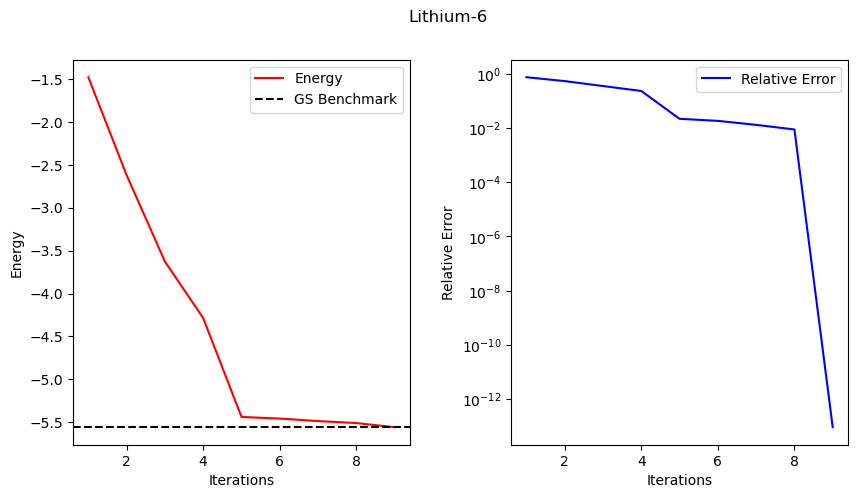

In [102]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
# Load data from file
data = np.loadtxt(f"{NucleiName}/" + NucleiName + '_energy.out')

# Extract columns from data
iterations = data[1:,0]
energy = data[1:,1]
rel_error = np.abs(data[1:,2])  # Take the absolute value of the relative error

# Create multiplot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot energy vs. iterations with benchmark on left subplot
ax1.plot(iterations, energy, 'r-', label="Energy")
ax1.axhline(y=GS_reference, color='k', linestyle='--', label="GS Benchmark")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Energy")
ax1.legend()
ax1.autoscale_view()  # Adjust axis to the data automatically

# Plot relative error vs. iterations on right subplot
ax2.plot(iterations, rel_error, 'b-', label="Relative Error")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Relative Error")

ax2.set_yscale("log")  # Set the y-axis to log scale
ax2.legend()

# Disable grid and minor ticks
ax2.grid(False)
ax2.minorticks_off()

ax2.autoscale_view()  # Adjust axis to the data automatically

# Add global title
fig.suptitle(NucleiName)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Save plot as PNG
plt.savefig(NucleiName + "multiplot.png")

# Show the plot
plt.show()

Explain the code

Now let me proceed for the case of the Beryllium-10 nucleus. This one as we will see is a bit more challenging one since it has 6 valence nucleons. The cool thing with this nucleus is that we will test a new ansatz to see how it performs. We will introduce 3 body fermionic operators. In the other two elements we could not introduce 3 body correlations since we only had 2 valence nucleons for each case.

In [202]:
# setup
nqubits = 12
HamiltonianFile = "input/hamiltonian_matrix_p_2_4.dat"
BasisFile = "input/many_body_states_p_2_4.dat"
epsilon = 0.01
initial_theta = 0.0

NucleiName = "Beryllium-10"

In [190]:
# We start reading the basis file and building all the non-zero Fermionic operators.
with open(BasisFile, 'r') as f:
    lines = f.readlines()[1:]
    vectors = [[int(i) for i in line.split('(')[1].split(')')[0].split(', ')] for line in lines]
NonZeroFermionicOperators(vectors, f"{NucleiName}/NonZeroFermionicOperators.out")
# Now we use the swap_elements function to create the T operators that we will use in the optimization.
swap_elements(f"{NucleiName}/NonZeroFermionicOperators.out", f"{NucleiName}/NonZeroFermionicOperatorsSwap.out")

Non-zero fermionic operators calculation:  2.906604766845703


In [191]:
# I create the Hamiltonian in the computational basis
H_sparse = transformH(HamiltonianFile, vectors, nqubits)

In [192]:
# I diagonaliize the Hamiltonian to obtain the GS energy for benchmarking my results.
def GS_benchmark(FileHamiltonian):
    # Read data from file
    with open(FileHamiltonian, "r") as f:
        data = np.loadtxt(f)

    # Construct sparse matrix from data
    hamiltonian = coo_matrix((data[:, 2], (data[:, 0].astype(int), data[:, 1].astype(int))))

    # Diagonalize Hamiltonian matrix and compute ground state energy
    evals, evecs = eigsh(hamiltonian, k=1, which="SA")
    ground_state_energy = evals[0]

    return ground_state_energy
GS_reference = GS_benchmark(HamiltonianFile)
print("GS Energy:",GS_reference)

GS Energy: -39.4534157980571


In [193]:
# first fermion operator
energy_list = []

initial_vector, energy_1 = StateMinEnergy(HamiltonianFile, vectors)
energy_list.append(energy_1)
print(initial_vector)
print(energy_1)

initial_vector_circuit = initial_state(initial_vector,nqubits) #We have the circuit with the initial state

qbit_basis_vect = [0 if i not in initial_vector.copy() else 1 for i in range(nqubits)]
number = binary_to_decimal(qbit_basis_vect, nqubits)

length = 2**nqubits
initial_vector_comp = csr_matrix(([1], ([number], [0])), shape=(length, 1))

list_theta = []
list_T_OF = []
T_expr1 = FermionOperatorMaxGradient(f"{NucleiName}/NonZeroFermionicOperators.out", f"{NucleiName}/NonZeroFermionicOperatorsSwap.out", initial_vector_comp, H_sparse, nqubits)[0]
list_T_OF.append(T_expr1)
print("T_expr1",T_expr1)
# Until here we have computed the first operator T that gives the maximum gradient.

[1, 2, 6, 7, 8, 9]
-28.96475
0 : ───
1 : ─X─
2 : ─X─
3 : ───
4 : ───
5 : ───
6 : ─X─
7 : ─X─
8 : ─X─
9 : ─X─
10: ───
11: ───
None
[(-0-1j) [1^ 2^ 4 5] +
1j [4^ 5^ 1 2], (-0-1j) [6^ 9^ 10 11] +
1j [10^ 11^ 6 9], (-0-1j) [7^ 8^ 10 11] +
1j [10^ 11^ 7 8]]
T_expr1 (-0-1j) [1^ 2^ 4 5] +
1j [4^ 5^ 1 2]


In [194]:
# Now we have to compute the first theta that gives the minimum energy and the value of the energy
res = minimize(lambda theta: expected_value1(theta, initial_vector_circuit, H_sparse, nqubits, T_expr1),
               [initial_theta], method='BFGS',tol=10**(-12))

theta1 = float(res.x[0])
print("Theta value:",theta1)
list_theta.append(theta1)

print(list_theta)

energy = res.fun
energy_list.append(energy)
print("Energy_value:",energy)

C:\Users\carlo\AppData\Local\Temp\ipykernel_10008\3691423828.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta = float(theta)


0 :     ────────────────────────────────────────────────────────────────────── ...
1 :     ─X──H─o────────────o─H──H──o────────────o─H──H──o────────────o─H──H──o ...
2 :     ─X──H─X─o────────o─X─H──H──X─o────────o─X─H──RX─X─o────────o─X─RX─RX─X ...
3 :     ────────|────────|───────────|────────|───────────|────────|────────── ...
4 :     ─H──────X─o────o─X───H──RX───X─o────o─X───RX─H────X─o────o─X───H──RX── ...
5 :     ─RX───────X─RZ─X─────RX─H──────X─RZ─X─────H──H──────X─RZ─X─────H──RX── ...
6 :     ─X──────────────────────────────────────────────────────────────────── ...
7 :     ─X──────────────────────────────────────────────────────────────────── ...
8 :     ─X──────────────────────────────────────────────────────────────────── ...
9 :     ─X──────────────────────────────────────────────────────────────────── ...
10:     ────────────────────────────────────────────────────────────────────── ...
11:     ────────────────────────────────────────────────────────────────────── ...

0 :

In [196]:
# new wavefunction after the first iteration
vect_comp_T, vect_T_circuit = combined_simulation1(theta1, initial_vector_circuit, nqubits, T_expr1)
vect_comp_T = csr_matrix(vect_comp_T).transpose()

0 :     ────────────────────────────────────────────────────────────────────── ...
1 :     ─X──H─o────────────o─H──H──o────────────o─H──H──o────────────o─H──H──o ...
2 :     ─X──H─X─o────────o─X─H──H──X─o────────o─X─H──RX─X─o────────o─X─RX─RX─X ...
3 :     ────────|────────|───────────|────────|───────────|────────|────────── ...
4 :     ─H──────X─o────o─X───H──RX───X─o────o─X───RX─H────X─o────o─X───H──RX── ...
5 :     ─RX───────X─RZ─X─────RX─H──────X─RZ─X─────H──H──────X─RZ─X─────H──RX── ...
6 :     ─X──────────────────────────────────────────────────────────────────── ...
7 :     ─X──────────────────────────────────────────────────────────────────── ...
8 :     ─X──────────────────────────────────────────────────────────────────── ...
9 :     ─X──────────────────────────────────────────────────────────────────── ...
10:     ────────────────────────────────────────────────────────────────────── ...
11:     ────────────────────────────────────────────────────────────────────── ...

0 :

Next, I am interested on studying a different ansatz. Instead of introducing two body correlations, I will introduce a new fermionic operator that consists on three body correlations and see how it performs.

In [197]:
print(initial_theta)
print(list_theta)
print(type(theta1))

0.0
[-0.27172406195103277]
<class 'float'>


In [198]:
# ITERATION
iteration = 1
while (abs(GS_reference)-abs(energy)) > epsilon:
    # Now we compute the next iteration of the algorithm:
    print("#-------------------------------------------------------")
    print("iteration:", iteration)

    T_expr = FermionOperatorMaxGradient(f"{NucleiName}/NonZeroFermionicOperators.out", f"{NucleiName}/NonZeroFermionicOperatorsSwap.out", vect_comp_T, H_sparse, nqubits)[0]
    list_T_OF.append(T_expr)

    res = minimize(lambda thetas: expected_value_iteration(thetas, list_T_OF, initial_vector_circuit, H_sparse, nqubits),
               [0.0] * len(list_T_OF), method='BFGS')


    list_theta = list(res.x)
    print(list_theta)

    energy = res.fun
    energy_list.append(energy)
    print(energy)

    # Now we compute the new vector:

    vect_comp_T, vect_T_circuit = vector_circuit_iteration(list_theta,list_T_OF,initial_vector_circuit,nqubits)
    print(vect_T_circuit.draw())
    #print(vect_comp_T)
    iteration = iteration + 1

#-------------------------------------------------------
iteration: 1
[(-0-1j) [6^ 9^ 10 11] +
1j [10^ 11^ 6 9], (-0-1j) [7^ 8^ 10 11] +
1j [10^ 11^ 7 8]]
[-0.28283979338405224, 0.4620800417998549]
-31.886179310364465
0 :     ────────────────────────────────────────────────────────────────────── ...
1 :     ─X──H─o────────────o─H──H──o────────────o─H──H──o────────────o─H──H──o ...
2 :     ─X──H─X─o────────o─X─H──H──X─o────────o─X─H──RX─X─o────────o─X─RX─RX─X ...
3 :     ────────|────────|───────────|────────|───────────|────────|────────── ...
4 :     ─H──────X─o────o─X───H──RX───X─o────o─X───RX─H────X─o────o─X───H──RX── ...
5 :     ─RX───────X─RZ─X─────RX─H──────X─RZ─X─────H──H──────X─RZ─X─────H──RX── ...
6 :     ─X──────────────────────────────────────────────────────────────────── ...
7 :     ─X──────────────────────────────────────────────────────────────────── ...
8 :     ─X──────────────────────────────────────────────────────────────────── ...
9 :     ─X─────────────────────────

ValueError: max() arg is an empty sequence

I don't know why the algorithm for Be-10 works perfecly until at iteration 12. There, is not able to find any fermionic operator that gives a non-zero gradient. I will try to simulate it through classical matrix multiplication to check if it is the algortihm that does not work or if the error is due a bug in the quantum circuit implementation.

**NOTE:** After successful implementation of the algorithm throught matrix simulation, I can confirm that there must be a bug in the quantum circuit implementation that is causing this error. I tried to figure this out but I was not successful to find anything wrong. Furthermore, the results obtained with quantum circuit simulation for the Oxygen-18 and the Lithium-6 were successfully implemented.

Beryllium-10 matrix simulation:

In [199]:
# We start importing all the libraries that we need:
import numpy as np
from openfermion.ops import FermionOperator
from openfermion.linalg import get_sparse_operator
from openfermion.utils import hermitian_conjugated
from scipy.optimize import minimize
from scipy.sparse.linalg import expm_multiply
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
import time
import re

In [204]:
# First we compute the vector with the minimum energy:
energy_list = [] # For then plot the energy as a function of the iterations

#We first compute the minimum energy vector
min_energ_vector, ADAPT_VQE_energy = StateMinEnergy(HamiltonianFile, vectors)
print("Minimum energy state:",min_energ_vector)
energy_list.append(ADAPT_VQE_energy)

qbit_basis_vect = [0 if i not in min_energ_vector else 1 for i in range(nqubits)]
number = binary_to_decimal(qbit_basis_vect, nqubits)

length = 2**nqubits
min_energ_vector = csr_matrix(([1], ([number], [0])), shape=(length, 1))

Minimum energy state: [1, 2, 6, 7, 8, 9]


In [205]:
#Now we have to make a function that computes the energy depending on a parameter theta and recieves a list of all the theta's
# and all the sparse_T's:
def expected_value(thetas, list_T_sparse, H_sparse, vector):
    """
    This function computes the expected value of the hamiltonian depending on a list of thetas.
    INPUT:
    thetas: List of parameters theta.
    list_T_sparse: List with all the sparse_T's.
    H_sparse: The sparse Hamiltonian matrix.
    vector: The vector in which we want to compute the expected value.
    OUTPUT:
    energy: The expected value of the energy.
    """
    psi = vector.copy()
    for i in range(len(thetas)):
        psi = expm_multiply(1.0j * thetas[i] * list_T_sparse[i], (psi))

    psic = np.conj(H_sparse.dot(psi)).transpose()
    result = (psic.dot(psi)[0, 0]).real
    return result

def compute_expected_value(theta):
    return expected_value(theta,list_theta,list_T_sparse,H_sparse,min_energ_vector)

#Now we build a list with all the theta's and all the sparse_T
list_T_sparse = []
list_theta = []

# We compute the first iteration of the algorithm:
T_expr1 = FermionOperatorMaxGradient(f"{NucleiName}/NonZeroFermionicOperators.out", f"{NucleiName}/NonZeroFermionicOperatorsSwap.out",min_energ_vector,H_sparse,nqubits)[0]
T1 = get_sparse_operator(T_expr1,nqubits)
list_T_sparse.append(T1)
with open(f"{NucleiName}"+'/Fermionic_operators.out', 'a') as f:
        f.write(str(T_expr1) + '\n')


print("FIRST_ENERGY:",ADAPT_VQE_energy)
print("--------------------------------------------------------------------")
#----------------------------------------------------------

res = minimize(lambda thetas: expected_value(thetas, list_T_sparse, H_sparse, min_energ_vector),
               [initial_theta], method='BFGS')#, tol = 10**(-10))

theta1 = res.x[0]
list_theta.append(theta1)
print("Theta0=",theta1)

energy = res.fun
energy_list.append(energy)
print("First energy iteration:",energy)

[(-0-1j) [1^ 2^ 4 5] +
1j [4^ 5^ 1 2], (-0-1j) [6^ 9^ 10 11] +
1j [10^ 11^ 6 9], (-0-1j) [7^ 8^ 10 11] +
1j [10^ 11^ 7 8]]
FIRST_ENERGY: -28.96475
--------------------------------------------------------------------
Theta0= -0.27172406620989986
First energy iteration: -30.01341800115237


In [208]:
def FermionOperatorMaxGradientevol(FileFermions,FileFermionsSwap,vector,sparse_H,nqubits,list_T_sparse,list_theta):
    """
    This function computes the maximum gradient for a given vector.
    INPUT:
    FileFermions: File with the non zero fermion operators.
    vector: The vector in which we want to compute the maximum gradient.
    sparse_H: The sparse Hamiltonian matrix.
    nqubits: Number of qubits.
    OUTPUT:
    max_T: list with all the operators T that gives the maximun gradient.
    """

    values = []
    operadors_utilitzats = []
    
    psi = vector.copy()
    for i in range(len(list_theta)):
        psi = expm_multiply(1.0j*list_theta[i]*list_T_sparse[i],(psi.copy())) #HA DE SER UN +1.0j

    # We compute the bra outside the loop since it is the same always, it does not depend on the fermionic operator.
    bra = np.conj(sparse_H.dot(psi)).transpose()

    with open(FileFermions, "r") as FermionOperators1, open(FileFermionsSwap, "r") as FermionOperators2:
        lines1 = FermionOperators1.readlines()
        lines2 = FermionOperators2.readlines()

        for (line1,line2) in zip(lines1,lines2):

            FO = FermionOperator(line1)
            FO_conj = FermionOperator(line2)

            T = 1.0j * (FO - FO_conj) # T = 1.0j * (FO - FO.conjugate())

            ket = get_sparse_operator(T, nqubits).dot(psi)
            valor = abs(2.0*(bra.dot(ket)[0,0]).imag)

            
            if valor != 0.0:
                values.append(valor)
                operadors_utilitzats.append(T)
                #print("Gradient value:", valor)
            

    Maxvalor = max(values)
    max_T = [operadors_utilitzats[i] for i in range(len(values)) if values[i] == Maxvalor]
    print(max_T)
    return max_T

# Now we compute the rest of the iterations of the algorithm.
#----------------------------------------------------------
iteration = 1
while (abs(GS_reference)-abs(energy)) > epsilon:
    # Now we compute the next iteration of the algorithm:
    print("----------------------------------------------------------")
    print("iteration:", iteration)
    T_expr = FermionOperatorMaxGradientevol(f"{NucleiName}/NonZeroFermionicOperators.out", f"{NucleiName}/NonZeroFermionicOperatorsSwap.out",min_energ_vector,H_sparse,nqubits,list_T_sparse,list_theta)[0]
    T = get_sparse_operator(T_expr,nqubits)
    list_T_sparse.append(T)


    with open(f"{NucleiName}"+'/Fermionic_operators.out', 'a') as f:
        f.write(str(T_expr) + '\n')

    res = minimize(lambda thetas: expected_value(thetas, list_T_sparse, H_sparse, min_energ_vector),
                   list_theta + [initial_theta], method='BFGS')

    list_theta = list(res.x)
    print("parameters_list",list_theta)

    energy = res.fun
    energy_list.append(energy)
    print("Energy:",energy)
    
    iteration = iteration + 1

----------------------------------------------------------
iteration: 1
[(-0-1j) [6^ 9^ 10 11] +
1j [10^ 11^ 6 9], (-0-1j) [7^ 8^ 10 11] +
1j [10^ 11^ 7 8]]
parameters_list [-0.28283983185974115, 0.4620800493667245]
Energy: -31.886179310364536
----------------------------------------------------------
iteration: 2
[(-0-1j) [7^ 8^ 10 11] +
1j [10^ 11^ 7 8]]
parameters_list [-0.29356508284514415, 0.42665962001872443, -0.293417417561502]
Energy: -32.931061973809584
----------------------------------------------------------
iteration: 3
[(-0-1j) [2^ 7^ 4 11] +
1j [4^ 11^ 2 7], (-0-1j) [1^ 8^ 5 10] +
1j [5^ 10^ 1 8]]
parameters_list [-0.2962831844199107, 0.39819218636892445, -0.29688988238434616, 0.21116312018360575]
Energy: -33.45042006868978
----------------------------------------------------------
iteration: 4
[(-0-1j) [1^ 8^ 5 10] +
1j [5^ 10^ 1 8]]
parameters_list [-0.323500933997342, 0.35705468701137977, -0.32410334097053517, 0.27929665810086557, 0.2792966258348686]
Energy: -34.29085

In [209]:
# Saving data
iteration_list = []
for i in range(len(energy_list)):
    iteration_list.append(i)

with open(f"{NucleiName}/" + NucleiName + '_energy.out', 'w') as f:
    for i, energy in zip(iteration_list, energy_list):
        rel_error = abs((energy - GS_reference) / GS_reference)
        f.write(str(i) + ' ' + str(energy) + ' ' + str(rel_error) + '\n')
#----------------------------------------------------------------------------------------------------
# Now we save all the theta values on a file:
print(list_theta)
with open(f"{NucleiName}/"+ NucleiName + 'theta_values.out', 'w') as f:
    for theta in list_theta:
        f.write(str(theta) + '\n')

[-0.1018263401500397, 0.2997638670463342, -0.31436306635638833, 0.10289562299236682, 0.09941170743677487, 0.6920069495744202, -0.29901636287309513, -0.2655317695497815, 0.4828368720040443, 0.19335166966699566, -0.1589546156640539, -0.16478056916719544, 0.20923286551704243, -0.18664039859276382, -0.23987046381873828, -0.12757764927682988, -0.2142869413664339, -0.2578292377201443, 0.15809138695342279, 0.05585187817549258, -0.7382170786476787, 0.21323151546513575, 0.5246530474659638, 0.1668648628221157, -0.025181966097387848, 0.24854088244304617, 0.46185101212615964, 0.18934383961979398, 0.3375722353571289, -0.1736474716085371, 0.2226358569483028, -0.018030787113472342, -0.1899363318248209, -0.25939281801524616, -0.34549077528722233, 0.04235830989902816, 0.1338634232887216, -0.08067866216978771, -0.03435539385368121, 0.056950299045852144, 0.05337927732124024, 0.11758745364541776, -0.10154558588574476, 0.11086795288502202]


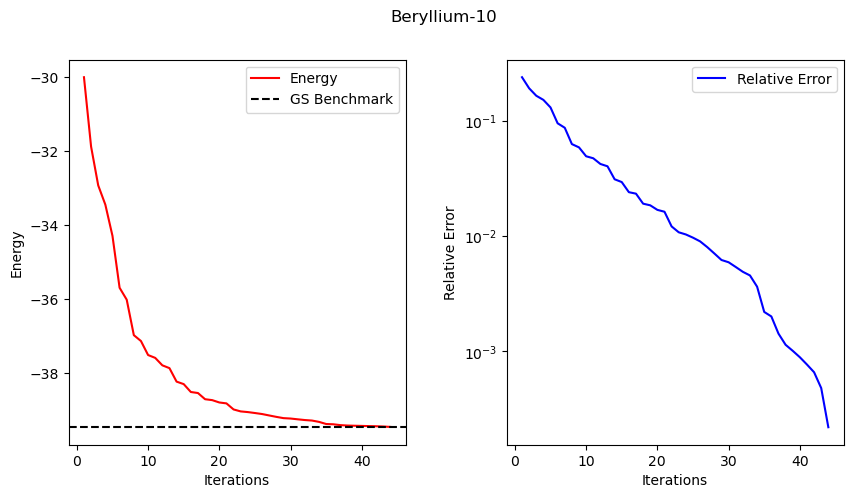

In [210]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
# Load data from file
data = np.loadtxt(f"{NucleiName}/" + NucleiName + '_energy.out')

# Extract columns from data
iterations = data[1:,0]
energy = data[1:,1]
rel_error = np.abs(data[1:,2])  # Take the absolute value of the relative error

# Create multiplot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot energy vs. iterations with benchmark on left subplot
ax1.plot(iterations, energy, 'r-', label="Energy")
ax1.axhline(y=GS_reference, color='k', linestyle='--', label="GS Benchmark")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Energy")
ax1.legend()
ax1.autoscale_view()  # Adjust axis to the data automatically

# Plot relative error vs. iterations on right subplot
ax2.plot(iterations, rel_error, 'b-', label="Relative Error")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Relative Error")

ax2.set_yscale("log")  # Set the y-axis to log scale
ax2.legend()

# Disable grid and minor ticks
ax2.grid(False)
ax2.minorticks_off()

ax2.autoscale_view()  # Adjust axis to the data automatically

# Add global title
fig.suptitle(NucleiName)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Save plot as PNG
plt.savefig(NucleiName + "multiplot.png")

# Show the plot
plt.show()

Let me now do a multiplot that includes all the simulations that we have done

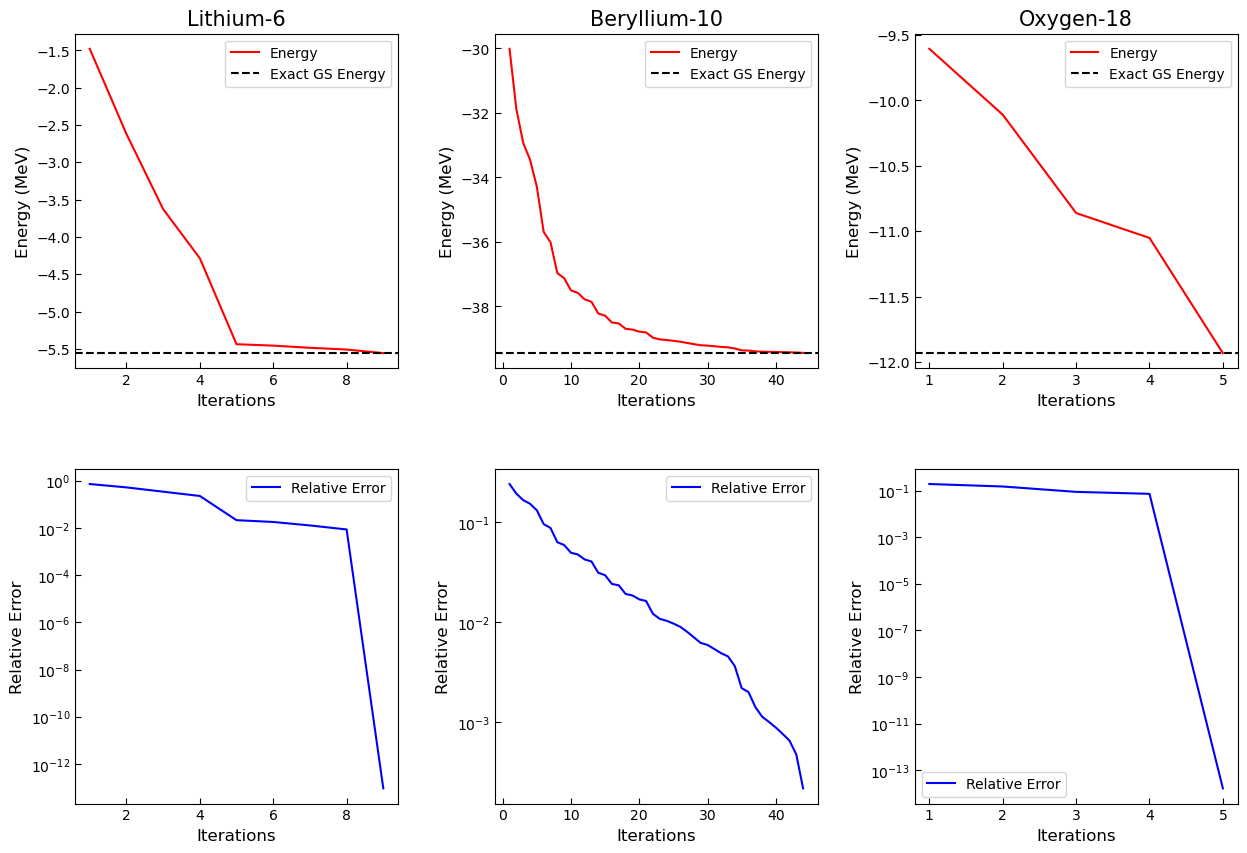

In [227]:

def GS_benchmark(FileHamiltonian):
    # Read data from file
    with open(FileHamiltonian, "r") as f:
        data = np.loadtxt(f)

    # Construct sparse matrix from data
    hamiltonian = coo_matrix((data[:, 2], (data[:, 0].astype(int), data[:, 1].astype(int))))

    # Diagonalize Hamiltonian matrix and compute ground state energy
    evals, evecs = eigsh(hamiltonian, k=1, which="SA")
    ground_state_energy = evals[0]

    return ground_state_energy

# List of nuclei names and their corresponding Hamiltonian files
nuclei_data = {
    "Lithium-6": "input/hamiltonian_matrix_p_1_1.dat", 
    "Beryllium-10": "input/hamiltonian_matrix_p_2_4.dat",
    "Oxygen-18": "input/hamiltonian_matrix_2_0.dat"
}

fig, axs = plt.subplots(2, len(nuclei_data), figsize=(15,10))

for i, (nuclei, file) in enumerate(nuclei_data.items()):
    # Load data from file
    data = np.loadtxt(f"{nuclei}/"+ nuclei +'_energy.out')

    # Extract columns from data
    iterations = data[1:,0]
    energy = data[1:,1]
    rel_error = np.abs(data[1:,2])  # Take the absolute value of the relative error

    # Get the benchmark energy
    GS_benchmark_value = GS_benchmark(file)

    # Plot energy vs. iterations with benchmark on top row
    axs[0, i].plot(iterations, energy, 'r-', label="Energy")
    axs[0, i].axhline(y=GS_benchmark_value, color='k', linestyle='--', label="Exact GS Energy")
    axs[0, i].set_xlabel("Iterations", fontsize=12)
    axs[0, i].set_ylabel("Energy (MeV)", fontsize=12)
    axs[0, i].legend()
    axs[0, i].autoscale_view()  # Adjust axis to the data automatically

    # Plot relative error vs. iterations on bottom row
    axs[1, i].plot(iterations, rel_error, 'b-', label="Relative Error")
    axs[1, i].set_xlabel("Iterations", fontsize=12)
    axs[1, i].set_ylabel("Relative Error", fontsize=12)
    axs[1, i].set_yscale("log")  # Set the y-axis to log scale
    axs[1, i].legend()

    # Disable grid and minor ticks
    axs[1, i].grid(False)
    axs[1, i].minorticks_off()
    axs[0, i].tick_params(axis='both', direction='in', length=4)
    axs[1, i].tick_params(axis='both', direction='in', length=4)

    axs[1, i].autoscale_view()  # Adjust axis to the data automatically
    

    # Add title for each column
    axs[0, i].set_title(nuclei, fontsize=15)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Save plot as PNG
plt.savefig("multiplot.png")

# Show the plot
plt.show()



Following this strategy, now I will try a new ansatz. I want to see how the algorithm performs when I introduce 3 body correlations. I will use the same initial state as before and I will introduce the following 3 body fermionic operators:

$$

$$

In [228]:
def NonZeroThreeBodyFermionicOperators(BasisVectors, FileName):
    """
    Input (list): This function receives a list of all the vectors of the basis (each is a list of occupied orbitals).
    Output (list): List of all the Non Zero three-body Fermionic operators of the form 
                   c_p^\dagger c_q^\dagger c_r^\dagger c_s c_t c_u.
    
    The basis states are given as lists of occupied orbitals. The operator is non-zero between vec1 and vec2 if:
      1) s, t, u are in vec1 and p, q, r are not in vec1.
      2) After removing s, t, u from vec1 and then adding p, q, r, we recover vec2 (or vice versa depending on ordering).
    """
    start_time = time.time()
    non_zero_operators = []

    # Determine min and max occupied orbitals from the entire basis
    components = [x for tup in BasisVectors for x in tup]
    maxc = max(components)
    minc = min(components)

    # Open file to write the operators
    with open(FileName, "w") as f:
        # Loop over all possible sets p,q,r and s,t,u
        # We use <= to avoid duplicates (p <= q <= r) and (s <= t <= u)
        for p in range(minc, maxc+1):
            for q in range(p, maxc+1):
                for r in range(q, maxc+1):
                    # Ensure distinctness of p,q,r if required:
                    if p == q or q == r or p == r:
                        continue

                    for s in range(minc, maxc+1):
                        for t in range(s, maxc+1):
                            for u in range(t, maxc+1):
                                # Ensure distinctness of s,t,u if required:
                                if s == t or t == u or s == u:
                                    continue
                                # Ensure that the sets {p,q,r} and {s,t,u} do not overlap if desired:
                                if (p in [s,t,u]) or (q in [s,t,u]) or (r in [s,t,u]):
                                    continue

                                # Now we check the basis vectors
                                for i in range(len(BasisVectors)):
                                    for j in range(len(BasisVectors)):
                                        vec1 = BasisVectors[i]
                                        vec2 = BasisVectors[j]

                                        # Condition for non-zero:
                                        # vec1 must have s,t,u and not have p,q,r
                                        if all(x in vec1 for x in [s,t,u]) and not any(x in vec1 for x in [p,q,r]):
                                            # After applying the annihilation operators c_u c_t c_s:
                                            vec1_copy = vec1.copy()
                                            for x_remove in [s,t,u]:
                                                vec1_copy.remove(x_remove)

                                            # After applying creation operators c_p^\dagger c_q^\dagger c_r^\dagger:
                                            vec1_copy.extend([p,q,r])
                                            vec1_copy.sort()

                                            # Check if this matches vec2
                                            vec2_sorted = sorted(vec2)
                                            if vec1_copy == vec2_sorted:
                                                # Construct the FermionOperator
                                                OF_Operator = FermionOperator(((p,1),(q,1),(r,1),(s,0),(t,0),(u,0)))
                                                if OF_Operator not in non_zero_operators:
                                                    non_zero_operators.append(OF_Operator)
                                                    f.write(str(OF_Operator) + "\n")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Non-zero three-body fermionic operators calculation:", elapsed_time)
    return non_zero_operators

In [229]:
# setup
nqubits = 12
HamiltonianFile = "input/hamiltonian_matrix_p_2_4.dat"
BasisFile = "input/many_body_states_p_2_4.dat"
epsilon = 0.01
initial_theta = 0.0

NucleiName = "Beryllium-10"

# We start reading the basis file and building all the non-zero Fermionic operators.
with open(BasisFile, 'r') as f:
    lines = f.readlines()[1:]
    vectors = [[int(i) for i in line.split('(')[1].split(')')[0].split(', ')] for line in lines]
NonZeroThreeBodyFermionicOperators(vectors, f"{NucleiName}/NonZero3BodyFermionicOperators.out")
# Now we use the swap_elements function to create the T operators that we will use in the optimization.
#swap_elements(f"{NucleiName}/NonZeroFermionicOperators.out", f"{NucleiName}/NonZeroFermionicOperatorsSwap.out")

Non-zero three-body fermionic operators calculation: 114.00557374954224


[1.0 [0^ 1^ 8^ 2 4 6],
 1.0 [0^ 1^ 8^ 4 5 6],
 1.0 [0^ 1^ 9^ 2 4 7],
 1.0 [0^ 1^ 9^ 2 4 10],
 1.0 [0^ 1^ 9^ 2 5 6],
 1.0 [0^ 1^ 9^ 3 4 6],
 1.0 [0^ 1^ 9^ 4 5 7],
 1.0 [0^ 1^ 9^ 4 5 10],
 1.0 [0^ 1^ 11^ 2 4 6],
 1.0 [0^ 1^ 11^ 4 5 6],
 1.0 [0^ 2^ 7^ 1 5 6],
 1.0 [0^ 2^ 7^ 4 5 6],
 1.0 [0^ 2^ 8^ 1 3 6],
 1.0 [0^ 2^ 8^ 1 4 11],
 1.0 [0^ 2^ 8^ 1 5 7],
 1.0 [0^ 2^ 8^ 1 5 10],
 1.0 [0^ 2^ 8^ 3 4 6],
 1.0 [0^ 2^ 8^ 4 5 7],
 1.0 [0^ 2^ 8^ 4 5 10],
 1.0 [0^ 2^ 9^ 1 3 7],
 1.0 [0^ 2^ 9^ 1 3 10],
 1.0 [0^ 2^ 9^ 1 5 8],
 1.0 [0^ 2^ 9^ 1 5 11],
 1.0 [0^ 2^ 9^ 3 4 7],
 1.0 [0^ 2^ 9^ 3 4 10],
 1.0 [0^ 2^ 9^ 3 5 6],
 1.0 [0^ 2^ 9^ 4 5 8],
 1.0 [0^ 2^ 9^ 4 5 11],
 1.0 [0^ 2^ 10^ 1 5 6],
 1.0 [0^ 2^ 10^ 4 5 6],
 1.0 [0^ 2^ 11^ 1 3 6],
 1.0 [0^ 2^ 11^ 1 4 8],
 1.0 [0^ 2^ 11^ 1 5 7],
 1.0 [0^ 2^ 11^ 1 5 10],
 1.0 [0^ 2^ 11^ 3 4 6],
 1.0 [0^ 2^ 11^ 4 5 7],
 1.0 [0^ 2^ 11^ 4 5 10],
 1.0 [0^ 3^ 6^ 1 4 7],
 1.0 [0^ 3^ 6^ 1 4 10],
 1.0 [0^ 3^ 7^ 1 2 10],
 1.0 [0^ 3^ 7^ 1 4 8],
 1.0 [0^ 3^ 7^ 1 4 11],
 1.0 [0^ 

In [231]:
def swap_elements_three_body(input_file_path, output_file_path):
    """
    This function is used to compute the three-body T operators by swapping the first three numbers 
    in the input file and using the last three numbers from the same line.
    """
    with open(input_file_path, 'r') as input_file, open(output_file_path, 'w') as output_file:
        # Regular expression to parse input lines
        line_regex = re.compile(r'(\d+\.\d+) \[(\d+)\^ (\d+)\^ (\d+)\^ (\d+) (\d+) (\d+)\]')

        # Iterate through all the lines in the input file
        for line in input_file:
            # Match the input line with the regex
            match = line_regex.match(line.strip())

            if match:
                # Extract matched elements
                value, p, q, r, s, t, u = match.groups()

                # Reconstruct the output line by swapping the first three numbers with the last three numbers
                output_line = f"{value} [{s}^ {t}^ {u}^ {p} {q} {r}]"

                # Write the output line to the output file
                output_file.write(output_line + '\n')


swap_elements_three_body(f"{NucleiName}/NonZero3BodyFermionicOperators.out", f"{NucleiName}/NonZero3BodyFermionicOperatorsSwap.out")

In [233]:
# and we go throught the same again:
# I create the Hamiltonian in the computational basis
H_sparse = transformH(HamiltonianFile, vectors, nqubits)
# I diagonaliize the Hamiltonian to obtain the GS energy for benchmarking my results.
def GS_benchmark(FileHamiltonian):
    # Read data from file
    with open(FileHamiltonian, "r") as f:
        data = np.loadtxt(f)

    # Construct sparse matrix from data
    hamiltonian = coo_matrix((data[:, 2], (data[:, 0].astype(int), data[:, 1].astype(int))))

    # Diagonalize Hamiltonian matrix and compute ground state energy
    evals, evecs = eigsh(hamiltonian, k=1, which="SA")
    ground_state_energy = evals[0]

    return ground_state_energy
GS_reference = GS_benchmark(HamiltonianFile)
print("GS Energy:",GS_reference)

GS Energy: -39.453415798057065


In [234]:
# First we compute the vector with the minimum energy:
energy_list = [] # For then plot the energy as a function of the iterations

#We first compute the minimum energy vector
min_energ_vector, ADAPT_VQE_energy = StateMinEnergy(HamiltonianFile, vectors)
print("Minimum energy state:",min_energ_vector)
energy_list.append(ADAPT_VQE_energy)

qbit_basis_vect = [0 if i not in min_energ_vector else 1 for i in range(nqubits)]
number = binary_to_decimal(qbit_basis_vect, nqubits)

length = 2**nqubits
min_energ_vector = csr_matrix(([1], ([number], [0])), shape=(length, 1))

Minimum energy state: [1, 2, 6, 7, 8, 9]


In [235]:
#Now we have to make a function that computes the energy depending on a parameter theta and recieves a list of all the theta's
# and all the sparse_T's:
def expected_value(thetas, list_T_sparse, H_sparse, vector):
    """
    This function computes the expected value of the hamiltonian depending on a list of thetas.
    INPUT:
    thetas: List of parameters theta.
    list_T_sparse: List with all the sparse_T's.
    H_sparse: The sparse Hamiltonian matrix.
    vector: The vector in which we want to compute the expected value.
    OUTPUT:
    energy: The expected value of the energy.
    """
    psi = vector.copy()
    for i in range(len(thetas)):
        psi = expm_multiply(1.0j * thetas[i] * list_T_sparse[i], (psi))

    psic = np.conj(H_sparse.dot(psi)).transpose()
    result = (psic.dot(psi)[0, 0]).real
    return result

def compute_expected_value(theta):
    return expected_value(theta,list_theta,list_T_sparse,H_sparse,min_energ_vector)

#Now we build a list with all the theta's and all the sparse_T
list_T_sparse = []
list_theta = []

# We compute the first iteration of the algorithm:
T_expr1 = FermionOperatorMaxGradient(f"{NucleiName}/NonZero3BodyFermionicOperators.out", f"{NucleiName}/NonZero3BodyFermionicOperatorsSwap.out",min_energ_vector,H_sparse,nqubits)[0]
T1 = get_sparse_operator(T_expr1,nqubits)
list_T_sparse.append(T1)
with open(f"{NucleiName}"+'/3BodyFermionic_operators.out', 'a') as f:
        f.write(str(T_expr1) + '\n')


print("FIRST_ENERGY:",ADAPT_VQE_energy)
print("--------------------------------------------------------------------")
#----------------------------------------------------------

res = minimize(lambda thetas: expected_value(thetas, list_T_sparse, H_sparse, min_energ_vector),
               [initial_theta], method='BFGS')#, tol = 10**(-10))

theta1 = res.x[0]
list_theta.append(theta1)
print("Theta0=",theta1)

energy = res.fun
energy_list.append(energy)
print("First energy iteration:",energy)

ValueError: max() arg is an empty sequence

In [237]:
def FermionOperatorMaxGradient(FileFermions, FileFermionsSwap, vector, sparse_H, nqubits):
    """
    Compute the maximum gradient for a given vector.
    """
    values = []
    operadors_utilitzats = []
    
    # Compute bra vector
    bra = np.conj(sparse_H.dot(vector)).transpose()

    with open(FileFermions, "r") as FermionOperators1, open(FileFermionsSwap, "r") as FermionOperators2:
        lines1 = FermionOperators1.readlines()
        lines2 = FermionOperators2.readlines()
        for (line1, line2) in zip(lines1, lines2):
            FO = FermionOperator(line1.strip())
            FO_conj = FermionOperator(line2.strip())

            T = 1.0j * (FO - FO_conj)  # Build the operator T

            # Sparse operator representation of T
            sparse_T = get_sparse_operator(T, nqubits)

            # Apply T to the vector
            ket = sparse_T.dot(vector)
            gradient_value = abs(2.0 * (bra.dot(ket)[0, 0]).imag)

            # Debugging
            print(f"Operator T: {T}")
            print(f"Gradient Value: {gradient_value}")
            if gradient_value != 0.0:
                print(f"Non-zero gradient found for operator T: {T}")
                values.append(gradient_value)
                operadors_utilitzats.append(T)

    if not values:
        print("No valid gradients found.")

    Maxvalor = max(values, default=0)
    max_T = [operadors_utilitzats[i] for i in range(len(values)) if values[i] == Maxvalor]
    print(f"Maximum Gradient Value: {Maxvalor}")
    return max_T

T_expr1 = FermionOperatorMaxGradient(f"{NucleiName}/NonZero3BodyFermionicOperators.out", f"{NucleiName}/NonZero3BodyFermionicOperatorsSwap.out",min_energ_vector,H_sparse,nqubits)[0]


Operator T: 1j [0^ 1^ 8^ 2 4 6] +
(-0-1j) [2^ 4^ 6^ 0 1 8]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 8^ 4 5 6] +
(-0-1j) [4^ 5^ 6^ 0 1 8]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 9^ 2 4 7] +
(-0-1j) [2^ 4^ 7^ 0 1 9]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 9^ 2 4 10] +
(-0-1j) [2^ 4^ 10^ 0 1 9]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 9^ 2 5 6] +
(-0-1j) [2^ 5^ 6^ 0 1 9]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 9^ 3 4 6] +
(-0-1j) [3^ 4^ 6^ 0 1 9]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 9^ 4 5 7] +
(-0-1j) [4^ 5^ 7^ 0 1 9]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 9^ 4 5 10] +
(-0-1j) [4^ 5^ 10^ 0 1 9]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 11^ 2 4 6] +
(-0-1j) [2^ 4^ 6^ 0 1 11]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 11^ 4 5 6] +
(-0-1j) [4^ 5^ 6^ 0 1 11]
Gradient Value: 0.0
Operator T: 1j [0^ 2^ 7^ 1 5 6] +
(-0-1j) [1^ 5^ 6^ 0 2 7]
Gradient Value: 0.0
Operator T: 1j [0^ 2^ 7^ 4 5 6] +
(-0-1j) [4^ 5^ 6^ 0 2 7]
Gradient Value: 0.0
Operator T: 1j [0^ 2^ 8^ 1 3 6] +
(-0-1j) [1

IndexError: list index out of range

As we can see, no valid gradients were found for any of the three-body fermionic operators in FermionOperatorMaxGradient. This suggests that none of the operators contribute to the gradient for the initial state. 
It will be interesting to study why does this happen, why we don't find anything.

Let me move to try with four body fermionic operators.

In [238]:
def NonZeroFourBodyFermionicOperators(BasisVectors, FileName):
    """
    Generates all the non-zero 4-body fermionic operators for a given basis.
    
    INPUT:
        BasisVectors (list): List of basis states (each as a list of occupied orbitals).
        FileName (str): Name of the file to save the non-zero operators.
        
    OUTPUT:
        non_zero_operators (list): List of all non-zero 4-body fermionic operators.
    """
    start_time = time.time()
    non_zero_operators = []  # List to store all non-zero 4-body operators

    # Find the smallest and largest indices in the basis
    components = [x for tup in BasisVectors for x in tup]
    maxc = max(components)
    minc = min(components)

    # Open the output file to save results
    with open(FileName, "w") as f:
        # Iterate over all possible combinations of indices
        for p in range(minc, maxc + 1):
            for q in range(p, maxc + 1):
                for r in range(q, maxc + 1):
                    for s in range(r, maxc + 1):
                        if len(set([p, q, r, s])) < 4:  # Skip if indices are not unique
                            continue

                        for t in range(minc, maxc + 1):
                            for u in range(t, maxc + 1):
                                for v in range(u, maxc + 1):
                                    for w in range(v, maxc + 1):
                                        if len(set([t, u, v, w])) < 4:  # Skip if indices are not unique
                                            continue

                                        # Check all pairs of basis states
                                        for i, vec1 in enumerate(BasisVectors):
                                            for j, vec2 in enumerate(BasisVectors):
                                                if i > j:  # Avoid redundant comparisons
                                                    continue

                                                # Conditions for vec1 and vec2 to connect via this operator
                                                if (all(x in vec1 for x in [t, u, v, w]) and
                                                        not any(x in vec1 for x in [p, q, r, s])):
                                                    # Remove t, u, v, w from vec1
                                                    vec1_copy = vec1.copy()
                                                    for x in [t, u, v, w]:
                                                        vec1_copy.remove(x)

                                                    # Add p, q, r, s to vec1_copy
                                                    vec1_copy.extend([p, q, r, s])
                                                    vec1_copy.sort()

                                                    # If vec1_copy matches vec2, create the operator
                                                    if sorted(vec1_copy) == sorted(vec2):
                                                        operator = FermionOperator(
                                                            ((p, 1), (q, 1), (r, 1), (s, 1),
                                                             (t, 0), (u, 0), (v, 0), (w, 0))
                                                        )

                                                        # Avoid duplicates
                                                        if operator not in non_zero_operators:
                                                            non_zero_operators.append(operator)
                                                            f.write(str(operator) + "\n")

    # Compute elapsed time
    elapsed_time = time.time() - start_time
    print(f"Non-zero 4-body fermionic operators calculation completed in {elapsed_time:.2f} seconds.")
    return non_zero_operators
# run
NonZeroFourBodyFermionicOperators(vectors, f"{NucleiName}/NonZero4BodyFermionicOperators.out")

Non-zero 4-body fermionic operators calculation completed in 696.83 seconds.


[1.0 [0^ 1^ 7^ 8^ 2 4 6 10],
 1.0 [0^ 1^ 7^ 8^ 4 5 6 10],
 1.0 [0^ 1^ 7^ 9^ 2 5 6 10],
 1.0 [0^ 1^ 7^ 9^ 3 4 6 10],
 1.0 [0^ 1^ 7^ 11^ 2 4 6 10],
 1.0 [0^ 1^ 7^ 11^ 4 5 6 10],
 1.0 [0^ 1^ 8^ 9^ 2 3 6 7],
 1.0 [0^ 1^ 8^ 9^ 2 3 6 10],
 1.0 [0^ 1^ 8^ 9^ 3 5 6 7],
 1.0 [0^ 1^ 8^ 9^ 3 5 6 10],
 1.0 [0^ 1^ 8^ 10^ 2 4 6 7],
 1.0 [0^ 1^ 8^ 10^ 4 5 6 7],
 1.0 [0^ 1^ 8^ 11^ 2 5 6 7],
 1.0 [0^ 1^ 8^ 11^ 2 5 6 10],
 1.0 [0^ 1^ 8^ 11^ 3 4 6 7],
 1.0 [0^ 1^ 8^ 11^ 3 4 6 10],
 1.0 [0^ 1^ 9^ 10^ 2 5 6 7],
 1.0 [0^ 1^ 9^ 10^ 3 4 6 7],
 1.0 [0^ 1^ 9^ 11^ 2 3 6 7],
 1.0 [0^ 1^ 9^ 11^ 2 3 6 10],
 1.0 [0^ 1^ 9^ 11^ 3 5 6 7],
 1.0 [0^ 1^ 9^ 11^ 3 5 6 10],
 1.0 [0^ 1^ 10^ 11^ 2 4 6 7],
 1.0 [0^ 1^ 10^ 11^ 4 5 6 7],
 1.0 [0^ 2^ 6^ 8^ 1 4 7 10],
 1.0 [0^ 2^ 6^ 9^ 1 5 7 10],
 1.0 [0^ 2^ 6^ 9^ 4 5 7 10],
 1.0 [0^ 2^ 6^ 11^ 1 4 7 10],
 1.0 [0^ 2^ 7^ 8^ 1 5 6 11],
 1.0 [0^ 2^ 7^ 8^ 4 5 6 11],
 1.0 [0^ 2^ 7^ 9^ 1 3 6 8],
 1.0 [0^ 2^ 7^ 9^ 1 3 6 11],
 1.0 [0^ 2^ 7^ 9^ 3 4 6 8],
 1.0 [0^ 2^ 7^ 9^ 3 4 6 11],
 1.0 [0^ 

In [240]:

def swap_elements_four_body(input_file_path, output_file_path):
    """
    This function computes the conjugate of four-body fermionic operators by swapping 
    the creation (^) and annihilation indices in the input file.
    
    Example: [p^ q^ r^ s^ t u v w] -> [t^ u^ v^ w^ p q r s]
    
    INPUT:
        input_file_path (str): Path to the file with four-body fermionic operators.
        output_file_path (str): Path to the file where swapped operators will be written.
    """
    with open(input_file_path, 'r') as input_file, open(output_file_path, 'w') as output_file:
        # Regular expression to parse four-body operators
        line_regex = re.compile(r'(\d+\.\d+)?\s*\[([\d+]\^) ([\d+]\^) ([\d+]\^) ([\d+]\^) ([\d+]) ([\d+]) ([\d+]) ([\d+])\]')
        
        # Iterate through all the lines in the input file
        for line in input_file:
            # Match the input line with the regex
            match = line_regex.match(line.strip())
            if match:
                # Extract matched elements
                value = match.group(1) if match.group(1) else ""
                p, q, r, s, t, u, v, w = match.groups()[1:]

                # Reconstruct the operator with swapped indices
                swapped_operator = f"{value} [{t}^ {u}^ {v}^ {w}^ {p} {q} {r} {s}]"

                # Write the swapped operator to the output file
                output_file.write(swapped_operator + '\n')

swap_elements_four_body(f"{NucleiName}/NonZero4BodyFermionicOperators.out", f"{NucleiName}/NonZero4BodyFermionicOperatorsSwap.out")


In [241]:
#Now we have to make a function that computes the energy depending on a parameter theta and recieves a list of all the theta's
# and all the sparse_T's:
def expected_value(thetas, list_T_sparse, H_sparse, vector):
    """
    This function computes the expected value of the hamiltonian depending on a list of thetas.
    INPUT:
    thetas: List of parameters theta.
    list_T_sparse: List with all the sparse_T's.
    H_sparse: The sparse Hamiltonian matrix.
    vector: The vector in which we want to compute the expected value.
    OUTPUT:
    energy: The expected value of the energy.
    """
    psi = vector.copy()
    for i in range(len(thetas)):
        psi = expm_multiply(1.0j * thetas[i] * list_T_sparse[i], (psi))

    psic = np.conj(H_sparse.dot(psi)).transpose()
    result = (psic.dot(psi)[0, 0]).real
    return result

def compute_expected_value(theta):
    return expected_value(theta,list_theta,list_T_sparse,H_sparse,min_energ_vector)

#Now we build a list with all the theta's and all the sparse_T
list_T_sparse = []
list_theta = []

# We compute the first iteration of the algorithm:
T_expr1 = FermionOperatorMaxGradient(f"{NucleiName}/NonZero4BodyFermionicOperators.out", f"{NucleiName}/NonZero4BodyFermionicOperatorsSwap.out",min_energ_vector,H_sparse,nqubits)[0]
T1 = get_sparse_operator(T_expr1,nqubits)
list_T_sparse.append(T1)
with open(f"{NucleiName}"+'/3BodyFermionic_operators.out', 'a') as f:
        f.write(str(T_expr1) + '\n')


print("FIRST_ENERGY:",ADAPT_VQE_energy)
print("--------------------------------------------------------------------")
#----------------------------------------------------------

res = minimize(lambda thetas: expected_value(thetas, list_T_sparse, H_sparse, min_energ_vector),
               [initial_theta], method='BFGS')#, tol = 10**(-10))

theta1 = res.x[0]
list_theta.append(theta1)
print("Theta0=",theta1)

energy = res.fun
energy_list.append(energy)
print("First energy iteration:",energy)

Operator T: 1j [0^ 1^ 7^ 8^ 2 4 6 10] +
(-0-1j) [2^ 3^ 6^ 7^ 0^ 1^ 8^ 9^]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 7^ 8^ 4 5 6 10] +
(-0-1j) [3^ 5^ 6^ 7^ 0^ 1^ 8^ 9^]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 7^ 9^ 2 5 6 10] +
(-0-1j) [1^ 3^ 6^ 8^ 0^ 2^ 7^ 9^]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 7^ 9^ 3 4 6 10] +
(-0-1j) [3^ 4^ 6^ 8^ 0^ 2^ 7^ 9^]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 7^ 11^ 2 4 6 10] +
(-0-1j) [1^ 2^ 7^ 8^ 0^ 3^ 6^ 9^]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 7^ 11^ 4 5 6 10] +
(-0-1j) [1^ 5^ 7^ 8^ 0^ 3^ 6^ 9^]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 8^ 9^ 2 3 6 7] +
(-0-1j) [2^ 4^ 7^ 8^ 0^ 3^ 6^ 9^]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 8^ 9^ 2 3 6 10] +
(-0-1j) [4^ 5^ 7^ 8^ 0^ 3^ 6^ 9^]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 8^ 9^ 3 5 6 7] +
(-0-1j) [1^ 2^ 6^ 9^ 0^ 3^ 7^ 8^]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 8^ 9^ 3 5 6 10] +
(-0-1j) [1^ 5^ 6^ 9^ 0^ 3^ 7^ 8^]
Gradient Value: 0.0
Operator T: 1j [0^ 1^ 8^ 10^ 2 4 6 7] +
(-0-1j) [2^ 4^ 6^ 9^

IndexError: list index out of range

Again we encounter the same issue. This suggests that to introduce this more complex fermion operators that introduce correlation between more 3 and 4 nucleons one should consider heavier nucleis with bigger single-particle states and more nucleons in this shell.